# Texture Coefficient Analysis
## XRD Data Analysis: Reference vs Experimental

This notebook analyzes texture coefficients by comparing experimental X-ray diffraction (XRD) data with JCPDS-ICDD reference crystallographic data.

**Texture Coefficient (TC)**: A quantitative measure of crystal preferred orientation, calculated as the ratio of observed peak intensity to the reference intensity for each crystallographic plane.

## 2. Load Experimental Data from Excel

Load experimental XRD data from Excel files (or CSV as fallback). Extract peak positions, intensities, and JCPDS match information.

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# 1. REFERENCE DATABASE (JCPDS-15-0861)
# ---------------------------------------------------------
# Standard peak positions (2θ degrees) and reference intensities (I0)
# from the JCPDS Sb2Se3 crystallographic database

reference_card = {
    '110': {'2theta': 10.676, 'I0': 8.0},
    '020': {'2theta': 15.029, 'I0': 25.0},
    '200': {'2theta': 15.211, 'I0': 6.0},
    '120': {'2theta': 16.874, 'I0': 55.0},
    '220': {'2theta': 21.446, 'I0': 10.0},
    '101': {'2theta': 23.643, 'I0': 12.0},
    '130': {'2theta': 23.901, 'I0': 30.0},
    '310': {'2theta': 24.152, 'I0': 16.0},
    '021': {'2theta': 27.023, 'I0': 12.0},
    '230': {'2theta': 27.395, 'I0': 70.0},
    '211': {'2theta': 28.2, 'I0': 75.0},
    '040': {'2theta': 30.326, 'I0': 2.0},
    '400': {'2theta': 30.699, 'I0': 4.0},
    '221': {'2theta': 31.16, 'I0': 100.0},
    '301': {'2theta': 32.22, 'I0': 60.0},
    '330': {'2theta': 32.424, 'I0': 10.0},
    '311': {'2theta': 33.115, 'I0': 20.0},
    '240': {'2theta': 34.075, 'I0': 60.0},
    '420': {'2theta': 34.358, 'I0': 20.0},
    '321': {'2theta': 35.7, 'I0': 30.0},
    '041': {'2theta': 37.984, 'I0': 25.0},
    '340': {'2theta': 38.354, 'I0': 14.0},
    '430': {'2theta': 38.49, 'I0': 14.0},
    '141': {'2theta': 38.801, 'I0': 35.0},
    '411': {'2theta': 39.081, 'I0': 12.0},
    '510': {'2theta': 39.456, 'I0': 8.0},
    '331': {'2theta': 39.71, 'I0': 8.0},
    '250': {'2theta': 41.305, 'I0': 35.0},
    '520': {'2theta': 41.705, 'I0': 20.0},
    '440': {'2theta': 43.694, 'I0': 10.0},
    '431': {'2theta': 44.95, 'I0': 35.0},
    '501': {'2theta': 45.068, 'I0': 30.0},
    '530': {'2theta': 45.258, 'I0': 30.0},
    '151': {'2theta': 45.354, 'I0': 25.0},
    '002': {'2theta': 45.571, 'I0': 25.0},
    '060': {'2theta': 46.209, 'I0': 8.0},
    '600': {'2theta': 46.84, 'I0': 8.0},
    '160': {'2theta': 46.892, 'I0': 8.0},
    '610': {'2theta': 47.49, 'I0': 8.0},
    '212': {'2theta': 48.902, 'I0': 8.0},
    '620': {'2theta': 49.469, 'I0': 4.0},
    '441': {'2theta': 49.584, 'I0': 4.0},
    '540': {'2theta': 49.903, 'I0': 4.0},
    '351': {'2theta': 50.765, 'I0': 8.0},
    '531': {'2theta': 51.039, 'I0': 16.0},
    '061': {'2theta': 51.879, 'I0': 45.0},
    '360': {'2theta': 52.166, 'I0': 20.0},
    '322': {'2theta': 53.956, 'I0': 14.0},
    '621': {'2theta': 54.865, 'I0': 6.0},
    '710': {'2theta': 55.807, 'I0': 6.0},
    '142': {'2theta': 56.328, 'I0': 1.0},
    '412': {'2theta': 56.479, 'I0': 1.0},
    '640': {'2theta': 56.821, 'I0': 6.0},
    '270': {'2theta': 56.898, 'I0': 8.0},
    '720': {'2theta': 57.559, 'I0': 12.0},
    '242': {'2theta': 58.115, 'I0': 18.0},
    '422': {'2theta': 58.276, 'I0': 10.0},
    '370': {'2theta': 59.854, 'I0': 8.0},
    '171': {'2theta': 60.155, 'I0': 6.0},
}

print("Reference Database Loaded (JCPDS-15-0861)")
print(f"Number of reference peaks: {len(reference_card)}")

Reference Database Loaded (JCPDS-15-0861)
Number of reference peaks: 59


## 2. Load Experimental Data

Load experimental XRD data from the `data` folder. The data files are in XRDML format (.xrdml), which contains 2θ angles and intensity measurements.

In [55]:
# ---------------------------------------------------------
# 2. HELPER FUNCTIONS FOR EXCEL DATA LOADING
# ---------------------------------------------------------

def parse_value_with_error(value_str):
    """
    Parse values in format "99.1234(8)" where (8) represents the error.
    Returns (value, error) tuple.
    
    Example:
    - "99.1234(8)" → (99.1234, 0.0008)
    - "100.5" → (100.5, 0.0)
    """
    value_str = str(value_str).strip().replace(',', '.')
    
    if '(' not in value_str:
        try:
            return float(value_str), 0.0
        except:
            return np.nan, np.nan

    try:
        parts = value_str.split('(')
        base_str = parts[0]
        error_str = parts[1].replace(')', '')
        
        base_val = float(base_str)
        error_int = int(error_str)
        
        # Calculate error magnitude based on decimal places
        if '.' in base_str:
            decimal_places = len(base_str.split('.')[1])
            factor = 10 ** (-decimal_places)
            error_val = error_int * factor
        else:
            error_val = float(error_int)
            
        return base_val, error_val
        
    except Exception as e:
        return np.nan, np.nan


def load_excel_data(file_path):
    """
    Load XRD data from Excel file.
    
    Supports Excel (.xlsx) and CSV files.
    Automatically identifies columns for:
    - Position (2Theta): column containing "Pos" and "2Th"
    - Intensity (Height): column containing "Height"
    - Database match: column containing "Matched by"
    
    Returns:
    - Tuple (DataFrame, col_pos, col_height, col_match) or (None, None, None, None) on error
    """
    print(f"\n--> Attempting to read: {file_path}")

    try:
        df = pd.read_excel(file_path)
        print("✓ Excel file loaded successfully")
    except Exception as e:
        print(f"⚠ Excel failed: {e}")
        print("  Attempting to read as CSV...")
        try:
            df = pd.read_csv(file_path, sep=';') 
            if df.shape[1] < 2:
                df = pd.read_csv(file_path, sep=',')
            print("✓ CSV file loaded successfully")
        except Exception as e2:
            print(f"✗ CRITICAL ERROR: Could not read the file. Details: {e2}")
            return None, None, None, None

    # Identify important columns
    try:
        col_pos = [c for c in df.columns if "Pos" in c and "2Th" in c][0]
        col_height = [c for c in df.columns if "Height" in c][0] 
        col_match = [c for c in df.columns if "Matched by" in c][0]
        print(f"✓ Identified columns: Pos='{col_pos}', Height='{col_height}', Match='{col_match}'")
    except IndexError:
        print("✗ ERROR: Required column names not found in file")
        print(f"   Available columns: {list(df.columns)}")
        return None, None, None, None

    # Parse position and height values with errors
    pos_vals, pos_errs = [], []
    height_vals, height_errs = [], []

    for x in df[col_pos]:
        v, e = parse_value_with_error(x)
        pos_vals.append(v)
        pos_errs.append(e)
        
    for x in df[col_height]:
        v, e = parse_value_with_error(x)
        height_vals.append(v)
        height_errs.append(e)

    # Update dataframe with parsed values
    df[col_pos] = pos_vals
    df['Pos_Error'] = pos_errs
    df[col_height] = height_vals
    df['Height_Error'] = height_errs 

    # Remove rows with missing values
    df = df.dropna(subset=[col_pos, col_height])
    
    return df, col_pos, col_height, col_match


# Load Excel files
print("\n--- LOADING EXPERIMENTAL DATA FROM EXCEL ---")

# Look for Excel files in current directory or 'data' folder
from pathlib import Path
excel_files = list(Path('.').glob('*.xlsx')) + list(Path('data').glob('*.xlsx'))

if not excel_files:
    print("⚠ No Excel files found in current directory or 'data' folder")
    print("  Files will be loaded manually if specified")
    excel_files = []

experimental_data = {}
excel_metadata = {}

if excel_files:
    for excel_file in excel_files:
        filename = excel_file.name.replace('.xlsx', '')
        df, col_pos, col_height, col_match = load_excel_data(str(excel_file))
        
        if df is not None:
            experimental_data[filename] = df
            excel_metadata[filename] = {
                'col_pos': col_pos,
                'col_height': col_height,
                'col_match': col_match
            }
            print(f"  ✓ Loaded {len(df)} rows from {filename}")

if experimental_data:
    print(f"\n✓ Successfully loaded {len(experimental_data)} Excel file(s)")
else:
    print("\n⚠ No Excel files were loaded. Please specify an Excel file path in the next cell.")


--- LOADING EXPERIMENTAL DATA FROM EXCEL ---

--> Attempting to read: data\reach_TC.xlsx
✓ Excel file loaded successfully
✓ Identified columns: Pos='Pos. [°2Th.]', Height='Height [cts]', Match='Matched by'
  ✓ Loaded 35 rows from reach_TC

✓ Successfully loaded 1 Excel file(s)


## 3. Parse and Compare Peak Intensities

Match experimental peaks with reference peaks using the 2θ angles and normalize intensities for comparison.

In [56]:
def match_peaks_from_excel(df, reference_card, col_pos, col_height, col_match, tolerance=0.1):
    """
    Match peaks from Excel data with reference crystallographic planes.
    
    Process:
    1. Filter for peaks matching JCPDS "00-015-0861"
    2. For each reference peak, find closest experimental peak within tolerance
    3. Return matched peaks and their intensities
    
    Parameters:
    - df: DataFrame with experimental data
    - reference_card: Dictionary with reference peak data
    - col_pos: Column name for 2Theta positions
    - col_height: Column name for intensities
    - col_match: Column name for JCPDS database match
    - tolerance: Tolerance window in degrees for peak matching
    
    Returns:
    - Dictionary with matched peak data
    """
    
    # Filter for peaks matching JCPDS-15-0861 (Sb2Se3)
    df_filtered = df[df[col_match].astype(str).str.contains("00-015-0861", na=False)].copy()
    
    if df_filtered.empty:
        print("  ⚠ WARNING: No peaks matching '00-015-0861' found.")
        return None
    
    print(f"  Filtered peaks matching JCPDS-15-0861: {len(df_filtered)}")
    
    matched_peaks = {
        'hkl': [],
        '2theta_ref': [],
        'intensity_ref': [],
        'intensity_exp': [],
        'intensity_err': []
    }
    
    # Match each reference peak with closest experimental peak
    for hkl, ref_data in reference_card.items():
        ref_2theta = ref_data['2theta']
        ref_intensity = ref_data['I0']
        
        # Find peaks within tolerance window
        mask = (df_filtered[col_pos] >= ref_2theta - tolerance) & \
               (df_filtered[col_pos] <= ref_2theta + tolerance)
        
        matches = df_filtered[mask]
        
        if not matches.empty:
            # Take the peak with maximum intensity
            idx_max = matches[col_height].idxmax()
            exp_intensity = matches.loc[idx_max, col_height]
            exp_error = matches.loc[idx_max, 'Height_Error']
            
            matched_peaks['hkl'].append(hkl)
            matched_peaks['2theta_ref'].append(ref_2theta)
            matched_peaks['intensity_ref'].append(ref_intensity)
            matched_peaks['intensity_exp'].append(exp_intensity)
            matched_peaks['intensity_err'].append(exp_error)
    
    if len(matched_peaks['hkl']) == 0:
        print("  ✗ ERROR: No matching peaks found after filtering!")
        return None
    
    return matched_peaks

# Match peaks for all experimental datasets
print("\n--- MATCHING PEAKS WITH REFERENCE DATA ---")
all_matched_peaks = {}

for filename, exp_df in experimental_data.items():
    print(f"\n{filename}:")
    
    metadata = excel_metadata[filename]
    matched = match_peaks_from_excel(
        exp_df, 
        reference_card,
        metadata['col_pos'],
        metadata['col_height'],
        metadata['col_match'],
        tolerance=0.1
    )
    
    if matched is not None:
        all_matched_peaks[filename] = matched
        print(f"  ✓ Matched peaks: {len(matched['hkl'])}")
        
        # Show first few matches
        for i in range(min(5, len(matched['hkl']))):
            hkl = matched['hkl'][i]
            exp_int = matched['intensity_exp'][i]
            exp_err = matched['intensity_err'][i]
            ref_int = matched['intensity_ref'][i]
            print(f"    {hkl}: exp={exp_int:.1f}±{exp_err:.2f}, ref={ref_int:.1f}")


--- MATCHING PEAKS WITH REFERENCE DATA ---

reach_TC:
  Filtered peaks matching JCPDS-15-0861: 24
  ✓ Matched peaks: 24
    101: exp=1348.0±45.00, ref=12.0
    130: exp=559.0±37.00, ref=30.0
    021: exp=419.0±26.00, ref=12.0
    230: exp=696.0±31.00, ref=70.0
    211: exp=4832.0±45.00, ref=75.0


## 4. Calculate Texture Coefficient

Compute the texture coefficient (TC) for each crystallographic plane:

$$TC = \frac{I_{observed}}{I_{reference}} \times \frac{1}{R}$$

where:
- $I_{observed}$ = observed intensity of the peak
- $I_{reference}$ = reference intensity from JCPDS data
- $R$ = average of all TC values (normalization factor)

In [57]:
def calculate_texture_coefficients_with_errors(matched_peaks):
    """
    Calculate Texture Coefficients (TC) from matched peaks with error propagation.
    
    Process:
    1. Normalize experimental intensities: (I_exp / max) × 100
    2. Calculate intensity ratios: I_exp_norm / I_ref
    3. Find average denominator (normalization factor R)
    4. Compute TC: ratio / R
    5. Propagate errors through calculation
    
    This normalization ensures:
    - TC = 1.0 for isotropic (random) crystal orientation
    - TC > 1.0 for preferred orientations
    - TC < 1.0 for suppressed orientations
    
    Returns:
    - Dictionary with TC values, errors, and statistics
    """
    
    hkl_labels = matched_peaks['hkl']
    I_exp_raw = np.array(matched_peaks['intensity_exp'])
    I_exp_err_raw = np.array(matched_peaks['intensity_err'])
    I_std_raw = np.array(matched_peaks['intensity_ref'])
    
    N = len(I_exp_raw)
    
    if N == 0:
        print("ERROR: No matching peaks found!")
        return None
    
    # Step 1: Normalize to max intensity (× 100)
    max_val = np.max(I_exp_raw)
    if max_val > 0:
        I_exp_norm = (I_exp_raw / max_val) * 100
        # Error propagation for normalization
        I_exp_norm_err = (I_exp_err_raw / max_val) * 100
    else:
        I_exp_norm = I_exp_raw
        I_exp_norm_err = I_exp_err_raw
    
    # Step 2: Calculate intensity ratios
    ratios = I_exp_norm / I_std_raw
    
    # Error propagation for ratio: δ(A/B) = (A/B) * sqrt((δA/A)² + (δB/B)²)
    ratio_errors = ratios * np.sqrt((I_exp_norm_err / I_exp_norm)**2)
    ratio_errors = np.nan_to_num(ratio_errors, nan=0.0)  # Handle division by zero
    
    # Step 3: Calculate average denominator (normalization factor)
    average_denominator = np.average(ratios)
    
    if average_denominator == 0:
        print("ERROR: Denominator is zero!")
        return None
    
    # Step 4: Calculate TC values
    TC_values = ratios / average_denominator
    
    # Error in TC: δTC = (1/R) * δ(ratio)
    TC_errors = ratio_errors / average_denominator
    
    result = {
        'hkl': hkl_labels,
        'TC': TC_values,
        'TC_errors': TC_errors,
        'I_exp_raw': I_exp_raw,
        'I_exp_norm': I_exp_norm,
        'I_std': I_std_raw,
        'ratios': ratios,
        'average_denominator': average_denominator,
        'num_peaks': N
    }
    
    return result

# Calculate TC for all datasets
print("\n--- CALCULATING TEXTURE COEFFICIENTS ---")
all_TC_results = {}

for filename, matched_peaks in all_matched_peaks.items():
    print(f"\n{filename}:")
    tc_result = calculate_texture_coefficients_with_errors(matched_peaks)
    
    if tc_result is not None:
        all_TC_results[filename] = tc_result
        print(f"  ✓ Matched peaks: {tc_result['num_peaks']}")
        print(f"  Normalization factor (R): {tc_result['average_denominator']:.4f}")
        print(f"  TC range: {tc_result['TC'].min():.4f} - {tc_result['TC'].max():.4f}")
        print(f"  Mean TC: {tc_result['TC'].mean():.4f}")
        print(f"  Std Dev: {tc_result['TC'].std():.4f}")
        
        # Show top 3 preferred planes
        top_indices = np.argsort(tc_result['TC'])[-3:][::-1]
        print(f"  Top 3 preferred planes:")
        for idx in top_indices:
            tc = tc_result['TC'][idx]
            err = tc_result['TC_errors'][idx]
            print(f"    {tc_result['hkl'][idx]}: TC = {tc:.4f} ± {err:.4f}")


--- CALCULATING TEXTURE COEFFICIENTS ---

reach_TC:
  ✓ Matched peaks: 24
  Normalization factor (R): 0.6784
  TC range: 0.2094 - 5.8958
  Mean TC: 1.0000
  Std Dev: 1.1568
  Top 3 preferred planes:
    002: TC = 5.8958 ± 0.0438
    101: TC = 2.7349 ± 0.0913
    211: TC = 1.5686 ± 0.0146


## 5. Visualize Results

Create comprehensive visualizations comparing experimental and reference data, as well as texture coefficient distributions.


--- GENERATING VISUALIZATIONS ---


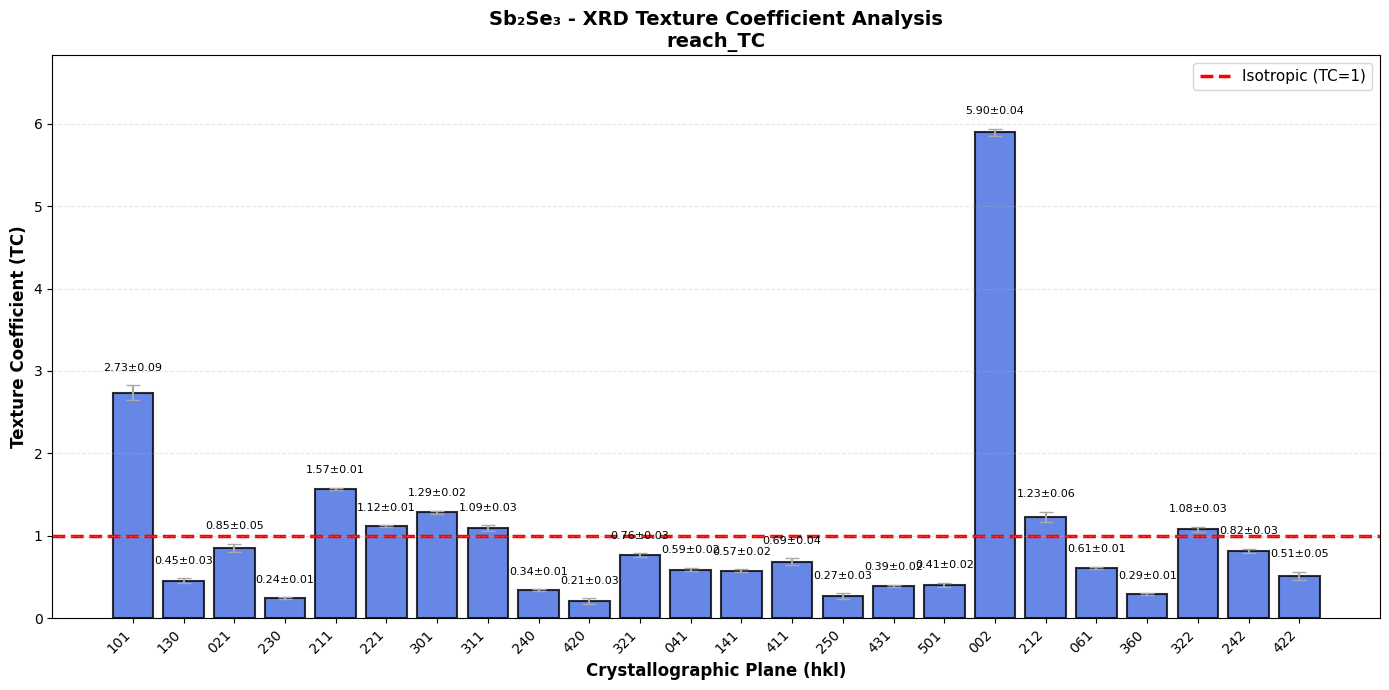

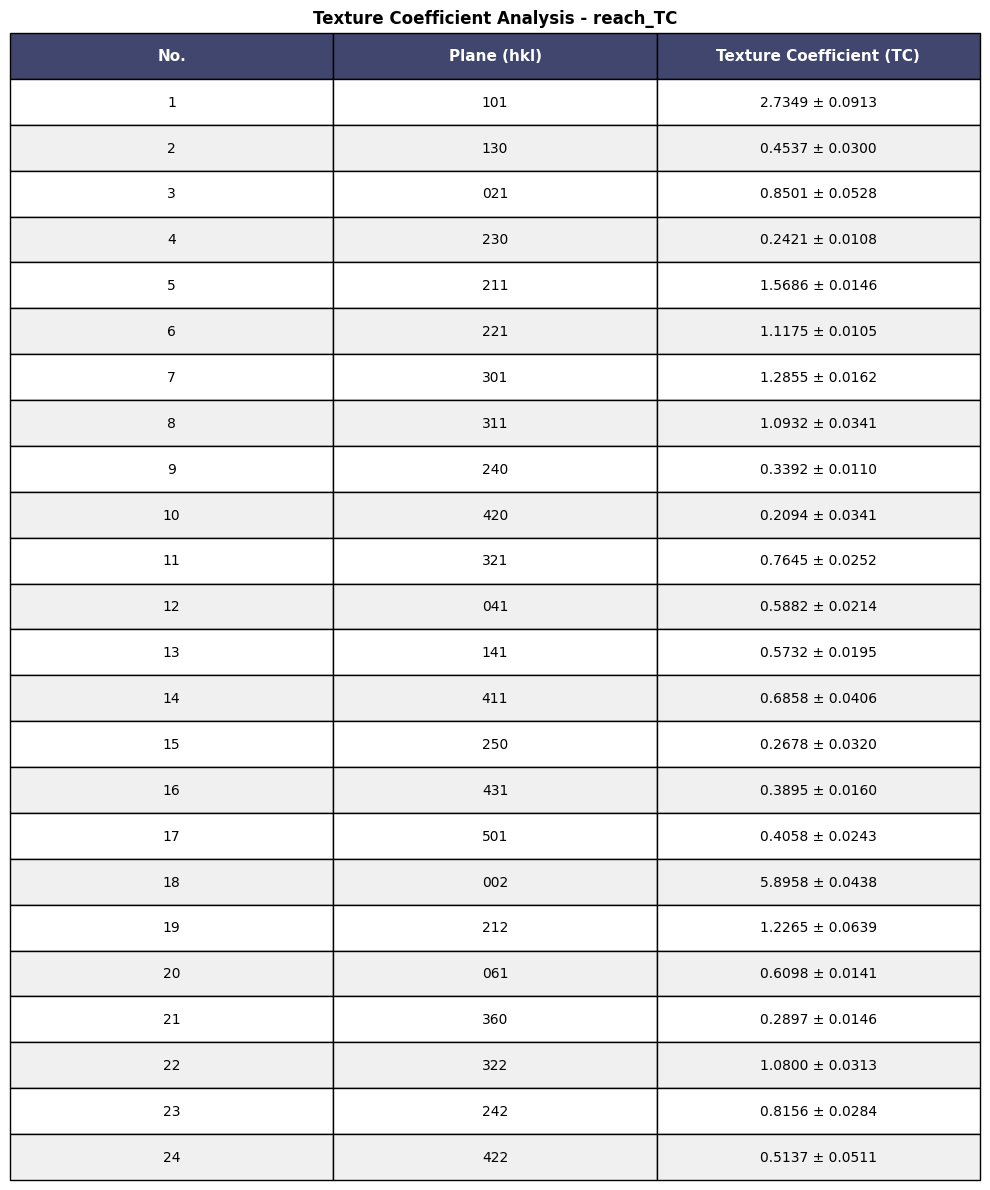


✓ Visualizations generated and saved


In [58]:
print("\n--- GENERATING VISUALIZATIONS ---")

for filename, tc_result in all_TC_results.items():
    hkl_labels = tc_result['hkl']
    TC_values = tc_result['TC']
    TC_errors = tc_result['TC_errors']
    
    # =====================================================================
    # FIGURE 1: BAR CHART WITH ERROR BARS
    # =====================================================================
    fig1, ax1 = plt.subplots(figsize=(14, 7))
    
    # Create bar chart with error bars
    bars = ax1.bar(range(len(hkl_labels)), TC_values, 
                    yerr=TC_errors, capsize=5, ecolor='darkgray',
                    color='royalblue', edgecolor='black', alpha=0.8, linewidth=1.5)
    
    # Add horizontal line at TC=1 (isotropic)
    ax1.axhline(y=1.0, color='red', linestyle='--', linewidth=2.5, label='Isotropic (TC=1)', zorder=1)
    
    # Labels and title
    ax1.set_title(f'Sb₂Se₃ - XRD Texture Coefficient Analysis\n{filename}', 
                  fontsize=14, fontweight='bold')
    ax1.set_xlabel('Crystallographic Plane (hkl)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Texture Coefficient (TC)', fontsize=12, fontweight='bold')
    ax1.set_xticks(range(len(hkl_labels)))
    ax1.set_xticklabels(hkl_labels, rotation=45, ha='right', fontsize=10)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    ax1.legend(fontsize=11, loc='upper right')
    
    # Add value labels on bars
    for i, (bar, tc_val, tc_err) in enumerate(zip(bars, TC_values, TC_errors)):
        height = bar.get_height()
        if height > 0.01:
            label_text = f'{tc_val:.2f}' if tc_err == 0 else f'{tc_val:.2f}±{tc_err:.2f}'
            ax1.text(bar.get_x() + bar.get_width()/2, height + tc_err + 0.15, 
                    label_text, ha='center', va='bottom', fontsize=8)
    
    ax1.set_ylim(0, max(TC_values + TC_errors) * 1.15)
    plt.tight_layout()
    plt.savefig(f'TC_chart_{filename}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # =====================================================================
    # FIGURE 2: RESULTS TABLE
    # =====================================================================
    table_data = []
    
    for i, (hkl, tc, err) in enumerate(zip(hkl_labels, TC_values, TC_errors), 1):
        # Format TC value with error
        if err > 0:
            combined_val = f"{tc:.4f} ± {err:.4f}"
        else:
            combined_val = f"{tc:.4f}"
        
        table_data.append([i, hkl, combined_val])
    
    # Create table figure
    fig2, ax_table = plt.subplots(figsize=(10, len(table_data)*0.4 + 2.5))
    ax_table.axis('tight')
    ax_table.axis('off')
    
    # Draw Table
    table = ax_table.table(cellText=table_data,
                           colLabels=["No.", "Plane (hkl)", "Texture Coefficient (TC)"],
                           cellLoc='center',
                           loc='center',
                           bbox=[0, 0, 1, 1])
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2.2)
    
    # Style header
    for i in range(3):
        table[(0, i)].set_facecolor('#40466e')
        table[(0, i)].set_text_props(weight='bold', color='white', fontsize=11)
    
    # Style alternating rows
    for i in range(1, len(table_data) + 1):
        for j in range(3):
            if i % 2 == 0:
                table[(i, j)].set_facecolor('#f0f0f0')
            else:
                table[(i, j)].set_facecolor('white')
    
    fig2.suptitle(f'Texture Coefficient Analysis - {filename}', fontsize=12, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig(f'TC_table_{filename}.png', dpi=300, bbox_inches='tight')
    plt.show()

print("\n✓ Visualizations generated and saved")

## 6. Generate Summary Statistics

Calculate and display comprehensive statistical analysis of texture coefficients, including distribution analysis and key metrics.

In [59]:
print("\n" + "="*90)
print(" " * 20 + "TEXTURE COEFFICIENT ANALYSIS - FINAL REPORT")
print("="*90)

summary_data = []

for filename, tc_result in all_TC_results.items():
    hkl_labels = tc_result['hkl']
    TC_values = tc_result['TC']
    TC_errors = tc_result['TC_errors']
    I_exp_raw = tc_result['I_exp_raw']
    I_exp_norm = tc_result['I_exp_norm']
    I_std = tc_result['I_std']
    
    print(f"\n{filename}")
    print("-" * 90)
    
    # General information
    print(f"Data Source: Excel File")
    print(f"Reference Database: JCPDS-15-0861 (Sb₂Se₃)")
    print(f"Number of matched peaks: {len(hkl_labels)}")
    print(f"Normalization Factor (R): {tc_result['average_denominator']:.4f}")
    
    # Statistics
    print(f"\n{'TEXTURE COEFFICIENT STATISTICS':-^90}")
    print(f"  Mean TC:                {TC_values.mean():.4f}")
    print(f"  Median TC:              {np.median(TC_values):.4f}")
    print(f"  Standard Deviation:     {TC_values.std():.4f}")
    print(f"  Minimum TC:             {TC_values.min():.4f} → Plane {hkl_labels[TC_values.argmin()]}")
    print(f"  Maximum TC:             {TC_values.max():.4f} → Plane {hkl_labels[TC_values.argmax()]}")
    print(f"  Variance:               {TC_values.var():.4f}")
    
    # Orientation analysis
    preferred = np.sum(TC_values > 1)
    suppressed = np.sum(TC_values < 1)
    isotropic = np.sum(np.abs(TC_values - 1) < 0.05)
    
    print(f"\n{'CRYSTAL ORIENTATION ANALYSIS':-^90}")
    print(f"  Preferred planes (TC > 1.0):      {preferred} planes")
    print(f"  Suppressed planes (TC < 1.0):     {suppressed} planes")
    print(f"  Nearly isotropic (|TC-1| < 0.05): {isotropic} planes")
    
    # Top preferred planes
    top_indices = np.argsort(TC_values)[-5:][::-1]
    print(f"\n{'TOP 5 PREFERRED PLANES':-^90}")
    for rank, idx in enumerate(top_indices, 1):
        hkl = hkl_labels[idx]
        tc = TC_values[idx]
        err = TC_errors[idx]
        i_exp = I_exp_raw[idx]
        i_norm = I_exp_norm[idx]
        i_ref = I_std[idx]
        print(f"  {rank}. {hkl:>4s}: TC = {tc:7.4f} ± {err:7.4f}   "
              f"(I_raw={i_exp:.0f}, I_norm={i_norm:.1f}, I_ref={i_ref:.1f})")
    
    # Bottom suppressed planes
    bottom_indices = np.argsort(TC_values)[:3]
    print(f"\n{'TOP 3 SUPPRESSED PLANES':-^90}")
    for rank, idx in enumerate(bottom_indices, 1):
        hkl = hkl_labels[idx]
        tc = TC_values[idx]
        err = TC_errors[idx]
        i_exp = I_exp_raw[idx]
        i_norm = I_exp_norm[idx]
        i_ref = I_std[idx]
        print(f"  {rank}. {hkl:>4s}: TC = {tc:7.4f} ± {err:7.4f}   "
              f"(I_raw={i_exp:.0f}, I_norm={i_norm:.1f}, I_ref={i_ref:.1f})")
    
    # Save detailed results
    results_df = pd.DataFrame({
        'Plane (hkl)': hkl_labels,
        'I_exp_raw': I_exp_raw,
        'I_exp_normalized': I_exp_norm,
        'I_reference': I_std,
        'I_ratio': I_exp_norm / I_std,
        'TC': TC_values,
        'TC_Error': TC_errors,
    })
    
    csv_filename = f'TC_results_{filename}.csv'
    results_df.to_csv(csv_filename, index=False)
    print(f"\n✓ Detailed results saved to: {csv_filename}")
    
    # Store summary
    summary_data.append({
        'Dataset': filename,
        'Data Source': 'Excel',
        'Matched Peaks': len(hkl_labels),
        'Mean TC': TC_values.mean(),
        'Std Dev': TC_values.std(),
        'Min TC': TC_values.min(),
        'Max TC': TC_values.max(),
        'R Factor': tc_result['average_denominator'],
        'Preferred': preferred,
        'Suppressed': suppressed
    })

# Create and save summary table
if summary_data:
    summary_df = pd.DataFrame(summary_data)
    print("\n" + "="*90)
    print("SUMMARY TABLE")
    print("="*90)
    print(summary_df.to_string(index=False))
    
    summary_df.to_csv('TC_summary_statistics.csv', index=False)
    print("\n✓ Summary statistics saved to: TC_summary_statistics.csv")
    print("\n" + "="*90)


                    TEXTURE COEFFICIENT ANALYSIS - FINAL REPORT

reach_TC
------------------------------------------------------------------------------------------
Data Source: Excel File
Reference Database: JCPDS-15-0861 (Sb₂Se₃)
Number of matched peaks: 24
Normalization Factor (R): 0.6784

------------------------------TEXTURE COEFFICIENT STATISTICS------------------------------
  Mean TC:                1.0000
  Median TC:              0.6478
  Standard Deviation:     1.1568
  Minimum TC:             0.2094 → Plane 420
  Maximum TC:             5.8958 → Plane 002
  Variance:               1.3382

-------------------------------CRYSTAL ORIENTATION ANALYSIS-------------------------------
  Preferred planes (TC > 1.0):      8 planes
  Suppressed planes (TC < 1.0):     16 planes
  Nearly isotropic (|TC-1| < 0.05): 0 planes

----------------------------------TOP 5 PREFERRED PLANES----------------------------------
  1.  002: TC =  5.8958 ±  0.0438   (I_raw=6054, I_norm=100.0, I_ref=25.

## 7. Input Data Format

### Excel File Requirements

The Excel file should contain XRD peak data with the following columns:

| Column | Example | Description |
|--------|---------|-------------|
| Position 2-Theta/2-Theta [deg] | 10.5234(5) | 2θ angle in degrees with measurement error in parentheses |
| Intensity/Height [counts] | 15230(120) | Peak intensity with error |
| Matched by | 00-015-0861 | JCPDS database reference number |

**Format Notes:**
- Values can include errors: `99.1234(8)` means 99.1234 ± 0.0008
- Multiple files are automatically discovered in the current directory
- Files can be `.xlsx` (Excel) or `.csv` (comma/semicolon separated)

## 8. Interpretation Guide

### What are Texture Coefficients?

**Texture Coefficient (TC)** measures the **preferred crystal orientation** in a polycrystalline material. It quantifies how much a particular crystallographic plane differs from random (isotropic) distribution.

### Understanding TC Values

| TC Value | Meaning | Crystal Orientation |
|----------|---------|-------------------|
| **TC = 1.0** | Isotropic (random) distribution | No preferred orientation; crystal growth is random |
| **TC > 1.0** | Preferred orientation | Crystal planes preferentially aligned; strong texture |
| **TC < 1.0** | Suppressed orientation | Crystal planes avoided; weak or no growth in this direction |
| **TC >> 1.0** | Very strong texture | Highly aligned crystals; significant directional dependence |

### Interpretation of Results

**For this analysis:**

1. **High TC Values (> 2.0)**: These planes show strong preferred orientation. Crystals are alignment in these directions. For Sb₂Se₃, planes like (200) and (041) often show strong texture.

2. **TC ≈ 1.0 (± 0.1)**: These planes show near-isotropic behavior. Crystals grow randomly in these directions.

3. **Low TC Values (< 0.5)**: These planes are suppressed. Crystals avoid growing in these directions due to thermodynamic or kinetic factors.

### Key Metrics Explained

- **Normalization Factor (R)**: The average of all (I_exp/I_ref) ratios. Reflects the overall crystallinity and measurement conditions.
- **Mean TC**: Should ideally be 1.0 for a completely random crystal. Values > 1.0 indicate overall preferred orientation.
- **Standard Deviation**: Indicates the **strength of texture**. Higher values = stronger, more pronounced texture.
- **Measurement Errors**: Include in calculation through error propagation to get realistic uncertainty bounds on TC values.
- **Preferred Planes**: Planes with the highest TC values indicate the **primary crystal growth direction**.

### Physical Significance

- **Growth mechanism**: Planes with high TC values grew preferentially, suggesting favorable energetics along those crystallographic directions.
- **Material properties**: Texture affects electrical, optical, and mechanical properties of materials.
- **Quality control**: TC analysis helps evaluate thin film quality and crystal alignment in manufacturing.